## Extract features using power spectral density 1D

Parameters that should be changed such that the script runs as intended: everything related to paths (cil_project_path, save_path, zip_scored, zip_query)

The script also can apply a window function on the power spectral density 1D. Vary the value of the variable **window_len**. This variable should be >=1. If winwod_len=1, then no windowing is applied (ie it will give as output the initial power spectral density in 1D). 

In [0]:
import argparse
import os
import numpy as np
import math
import itertools

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image
import pandas as pd

import torchvision.utils as vutils

import cv2

from scipy import ndimage

# Parameters

In [0]:
window_len = 5
save_visualize = False # if set, it will save the visualization of the features to given path
save_csv = False # if set, dataframes for query and scored will be exported to drive

# Setup

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import query and scored files

In [0]:
# paths
base_dir = "drive/My Drive/"
cil_project_path = "/content/drive/My Drive/CIL_project/"
save_path = cil_project_path + "results_PSD1D/"

In [69]:
# get scored images
zip_scored = 'scored.zip'
path_scored = zip_scored[:-4] + '/'
path_scored_drive = cil_project_path + zip_scored

! cp '{path_scored_drive}' . 
! unzip -q '{zip_scored}'
! rm '{zip_scored}'

print('ok')

replace scored/8225396.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
ok


In [70]:
# number of images in scored
! ls -l '{path_scored}'| grep -v ^l | wc -l

9601


In [71]:
# get query.zip stuff
zip_query = 'query.zip'
path_query = zip_query[:-4] + '/'
path_query_drive = cil_project_path + zip_query

! cp '{path_query_drive}' . 
! unzip -q '{zip_query}'
! rm '{zip_query}'

print('ok')

replace query/5867953.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
ok


In [72]:
# number of images in query
! ls -l '{path_query}'| grep -v ^l | wc -l

1201


In [0]:
# get csv for scored
csv_name = 'scored.csv'
csv_path = csv_name
csv_drive_path = cil_project_path + csv_name

! cp '{csv_drive_path}' . 

In [74]:
scores = pd.read_csv(csv_path, index_col="Id")
scores

,Actual
Id,
5694059,1.837794
9129611,0.002067
8058479,4.588517
1315360,2.325835
6813515,0.872309
...,...
1639624,1.653025
4342102,1.279719
6526641,1.308388


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe245a327b8>]],
      dtype=object)

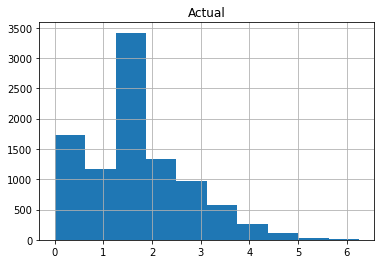

In [75]:
scores.hist()

In [76]:
scores.max()

Actual    6.249791
dtype: float64

# Azimuthally Averaged 1D Power Spectrum Density
source: https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59

In [0]:
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D

# Analyze for one image

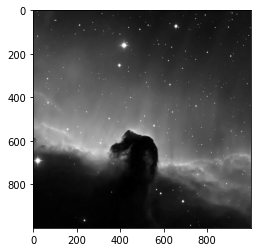

In [78]:
# 8058479 - image with score 4
# 8553726 - image with score 0
img_path = os.path.join(path_scored, "8553726.png")
img = cv2.imread(img_path,0) # load image

plt.imshow(img, cmap = 'gray')

In [0]:
# fourier
f = np.fft.fft2(img, norm=None)

# center 
f = np.fft.fftshift(f)

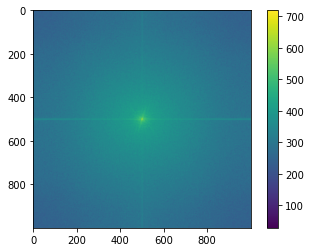

In [80]:
# magnitude
magnitude_db = 20 * np.log(np.abs(f) ** 2)
plt.imshow(magnitude_db)
plt.colorbar()

8579931582.711588
4079522141672769.0


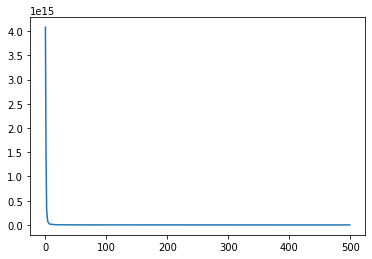

In [81]:
# np.abs(fft)^2 is signal power 
# use Azimuthally Averaged 1D PSD
psd1d = GetPSD1D(np.abs(f) ** 2)
plt.plot(psd1d)
print(np.min(psd1d))
print(np.max(psd1d))

# Make the visualisation files for PSD1D 

=== Score is  0


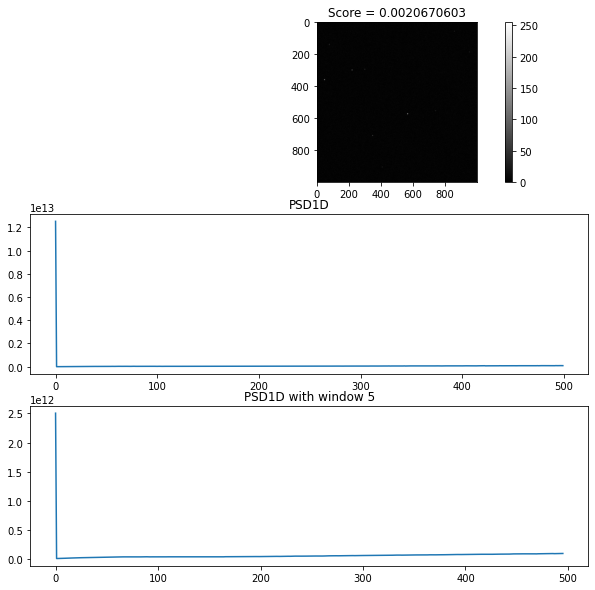

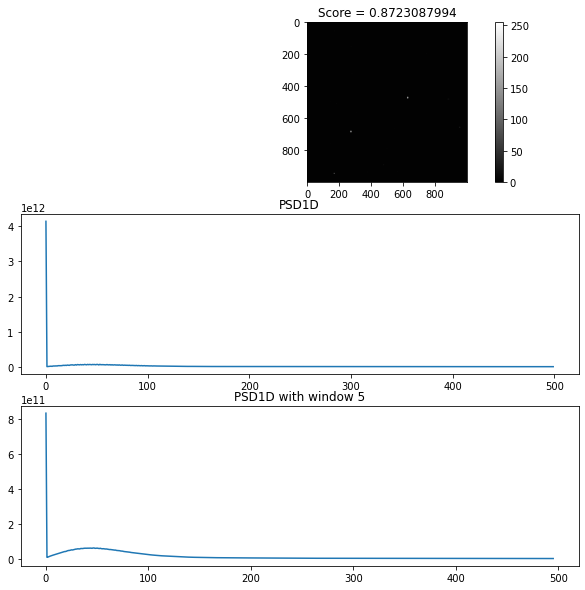

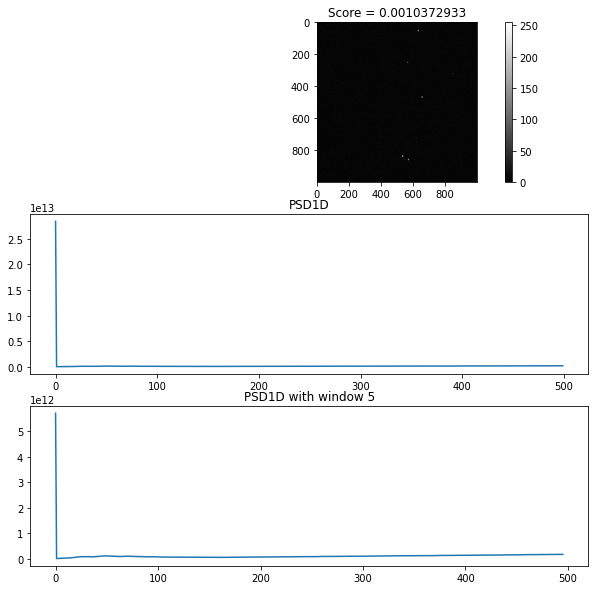

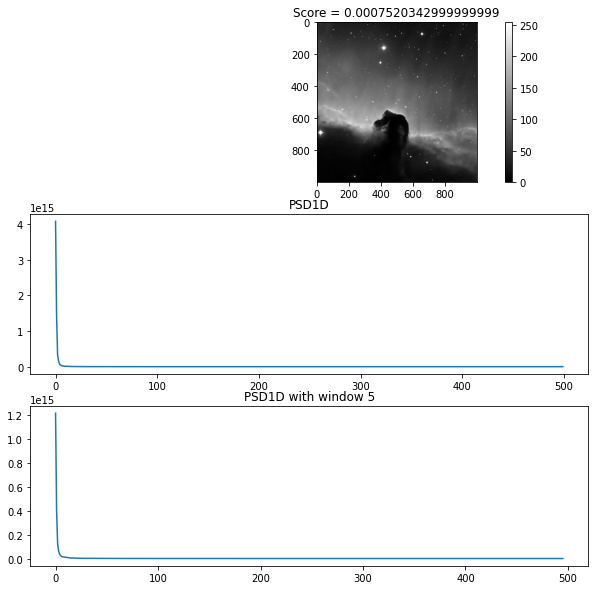

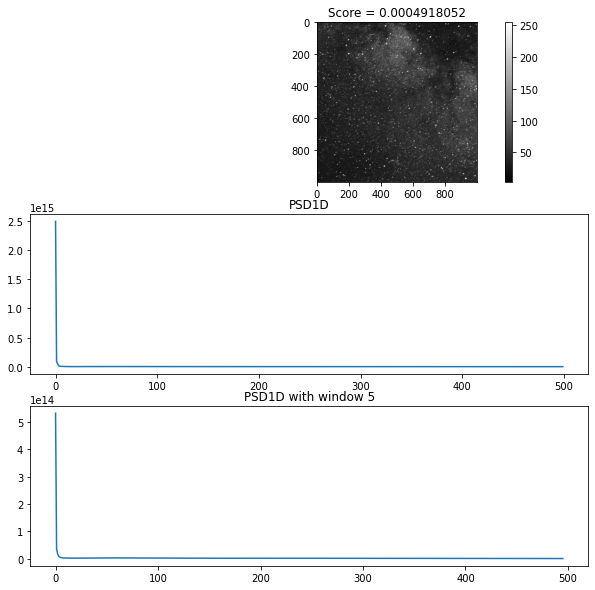

=== Score is  1


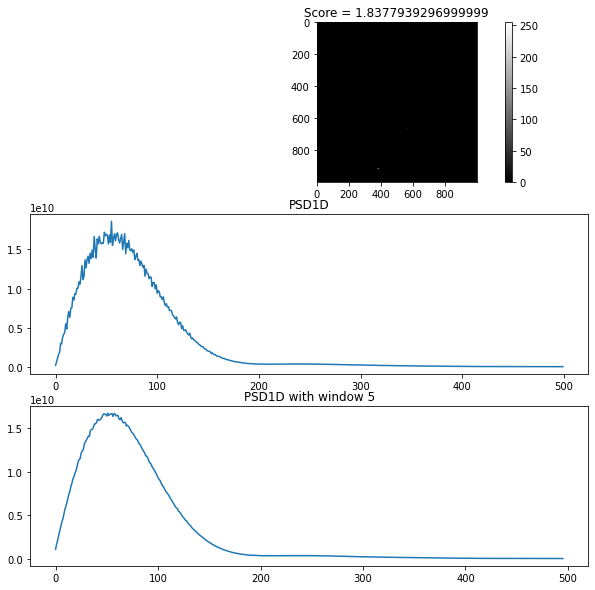

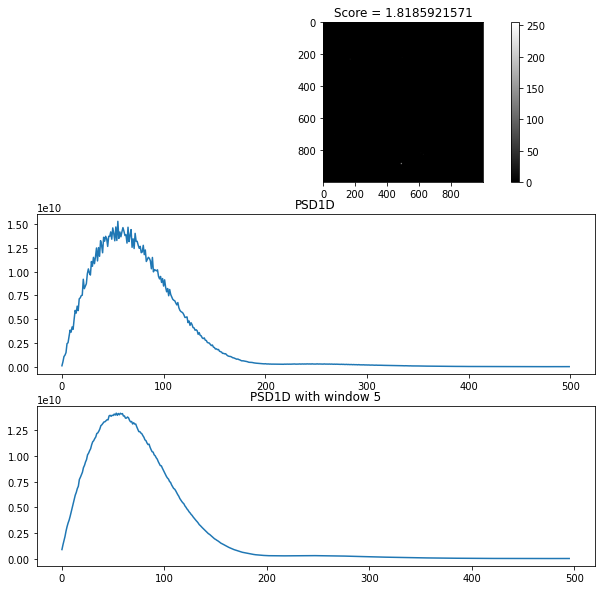

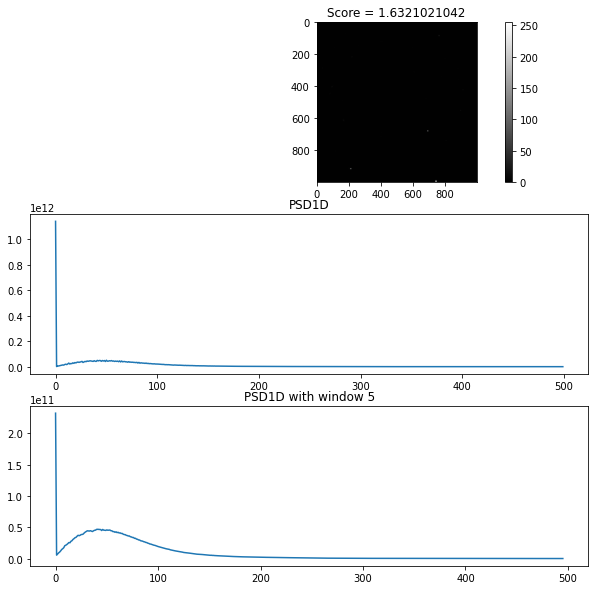

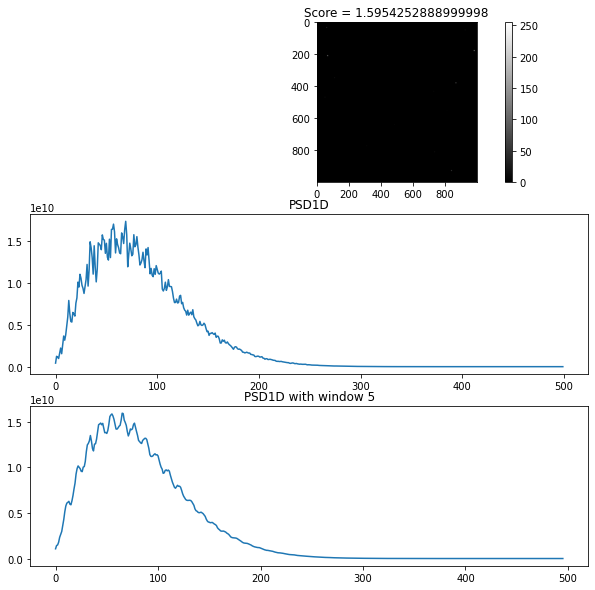

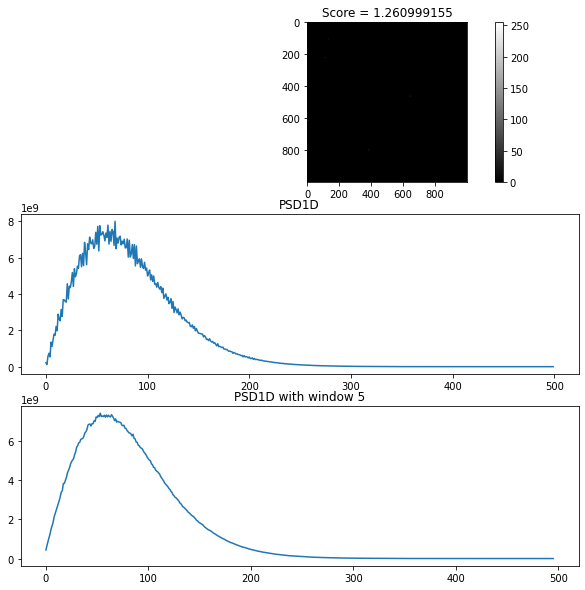

=== Score is  2


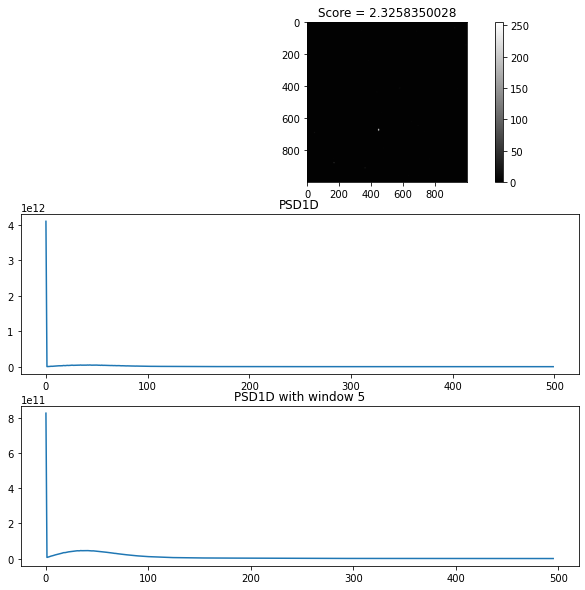

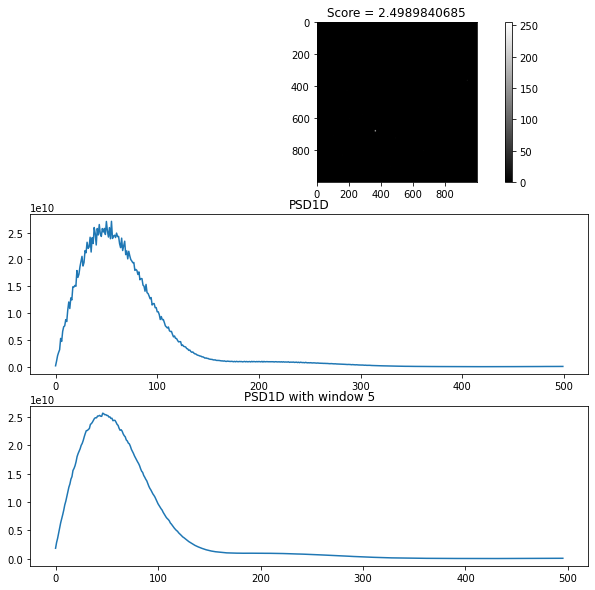

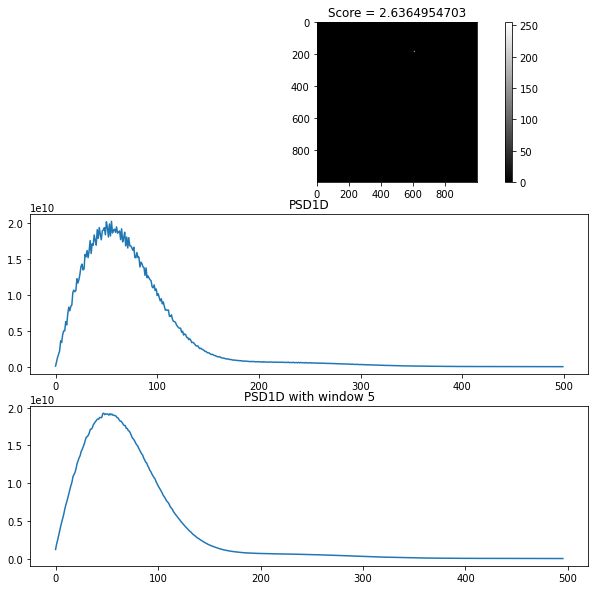

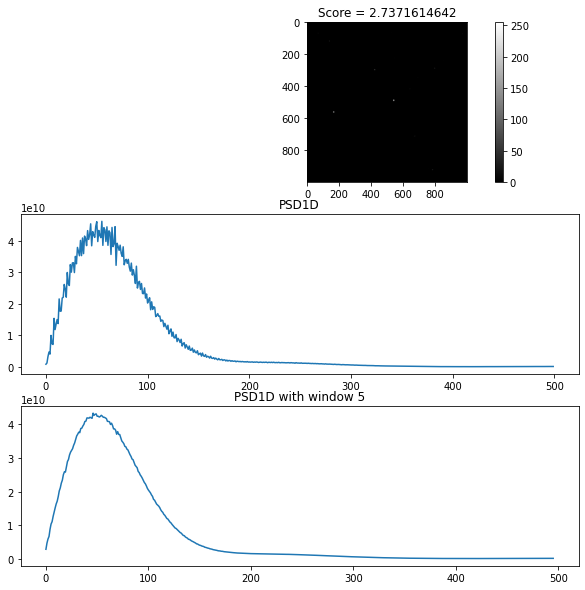

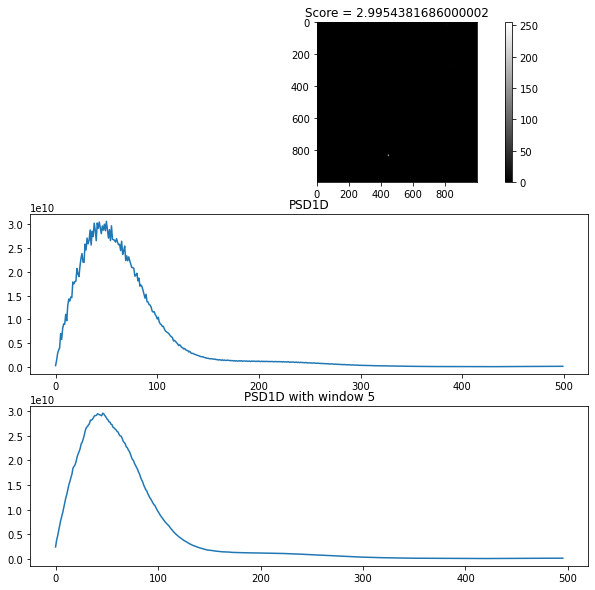

=== Score is  3


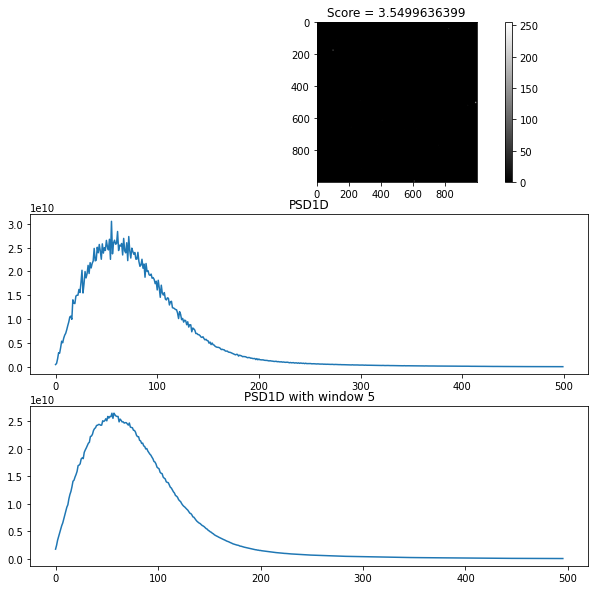

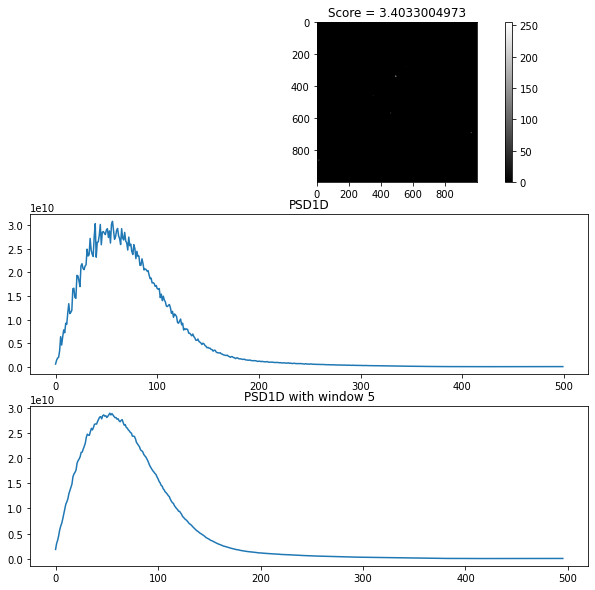

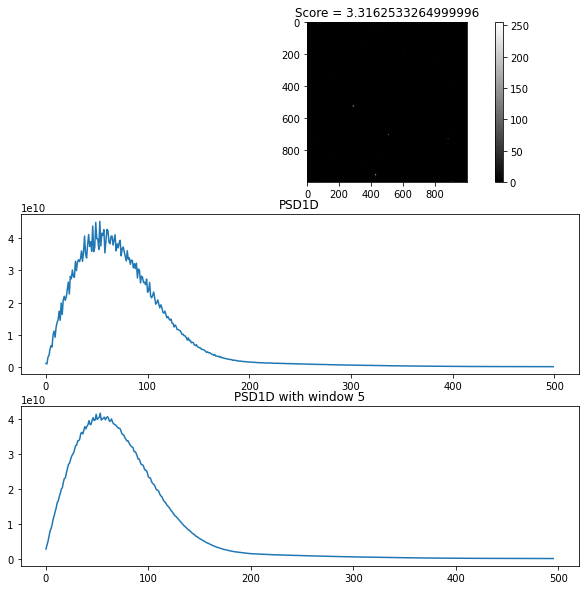

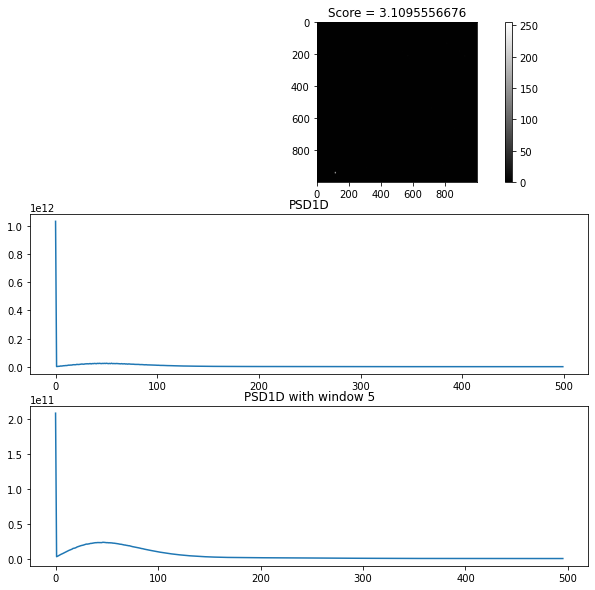

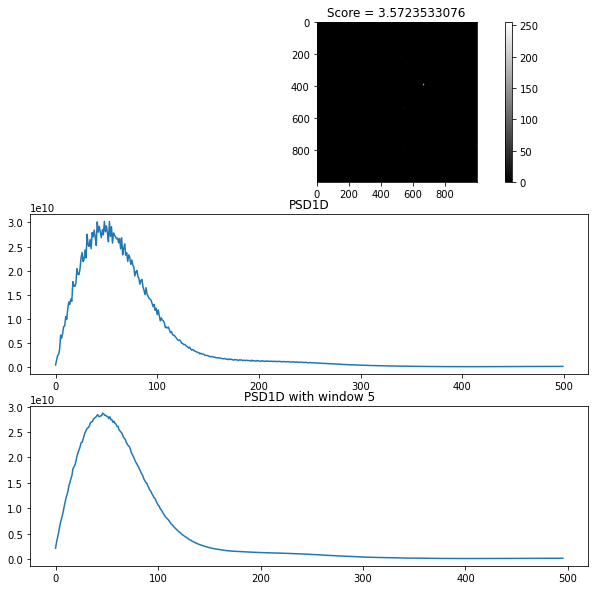

=== Score is  4


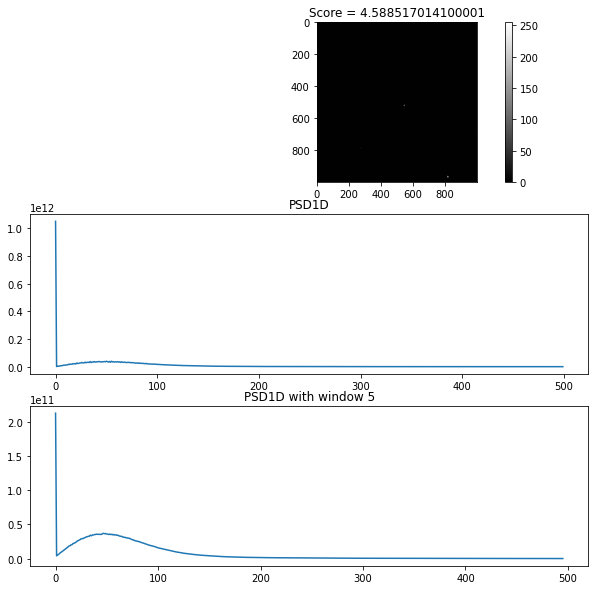

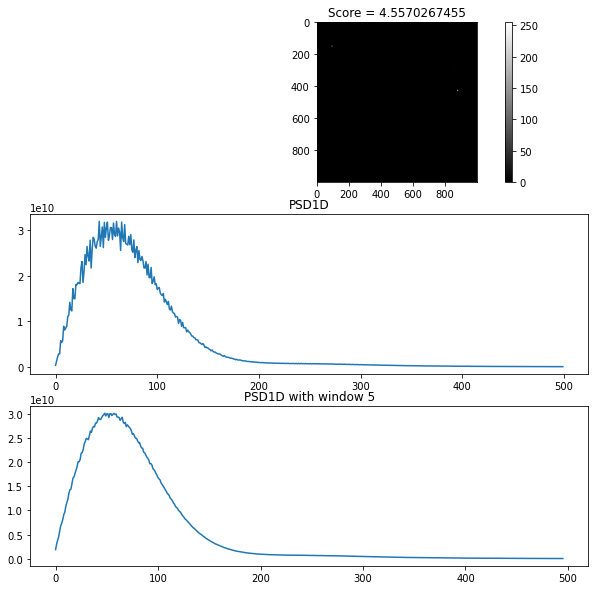

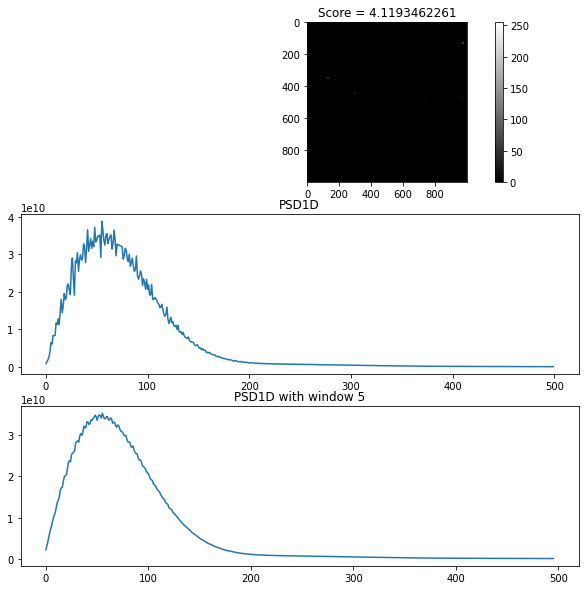

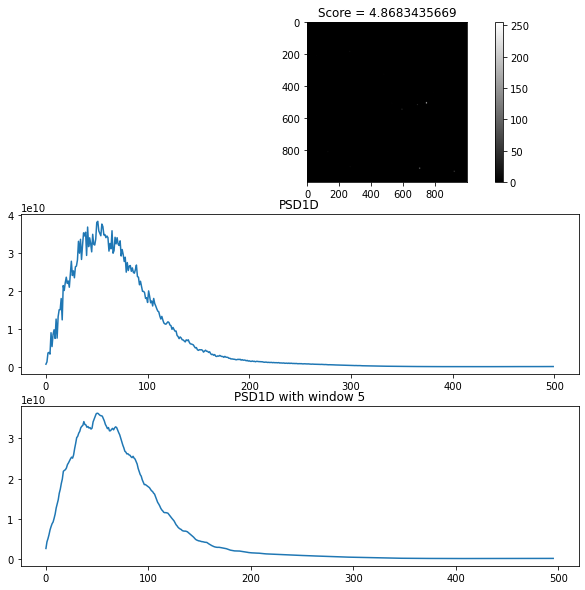

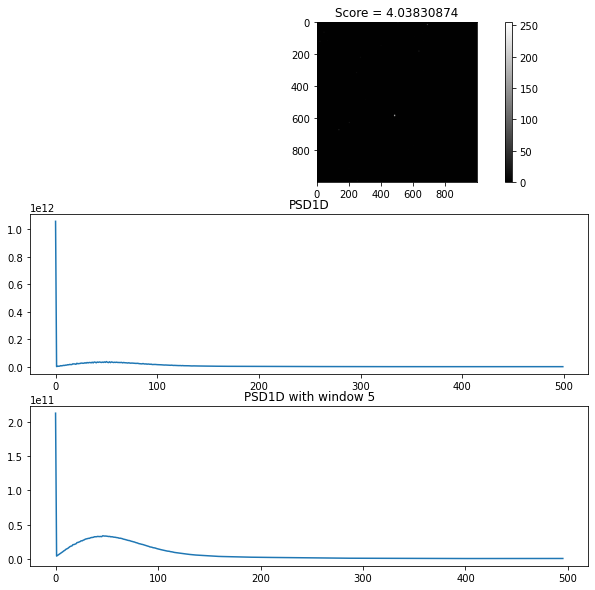

=== Score is  5


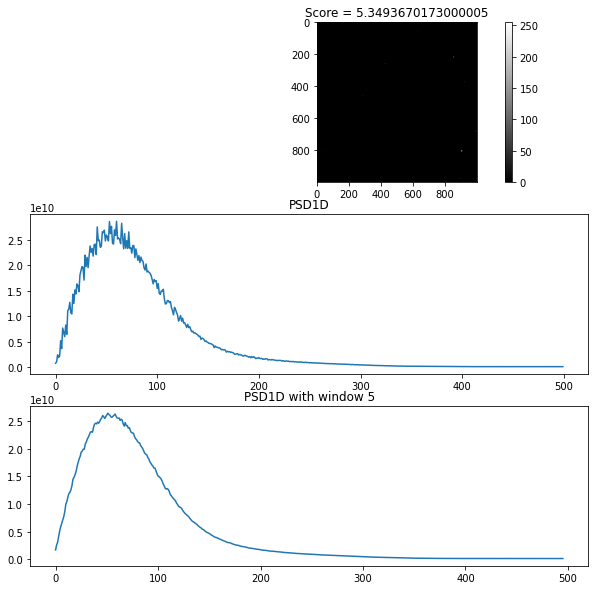

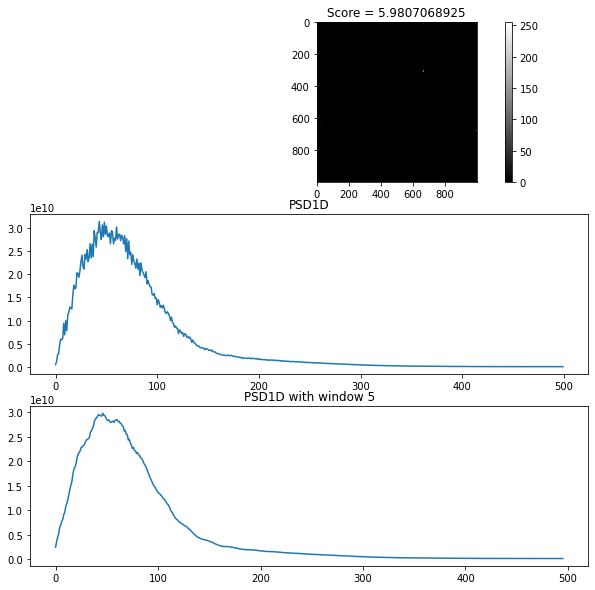

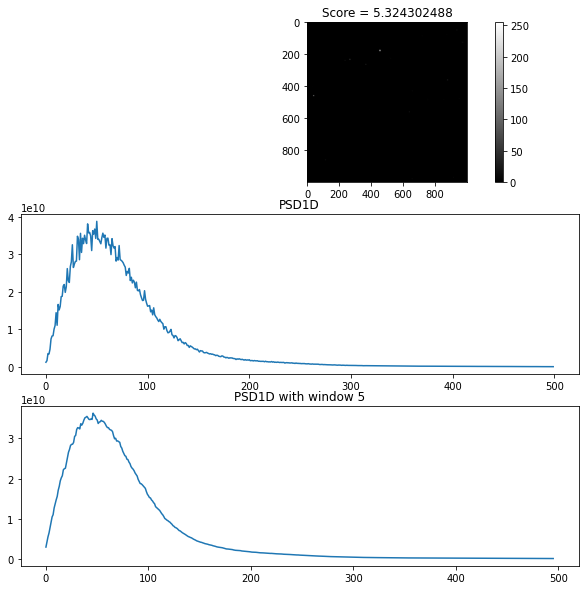

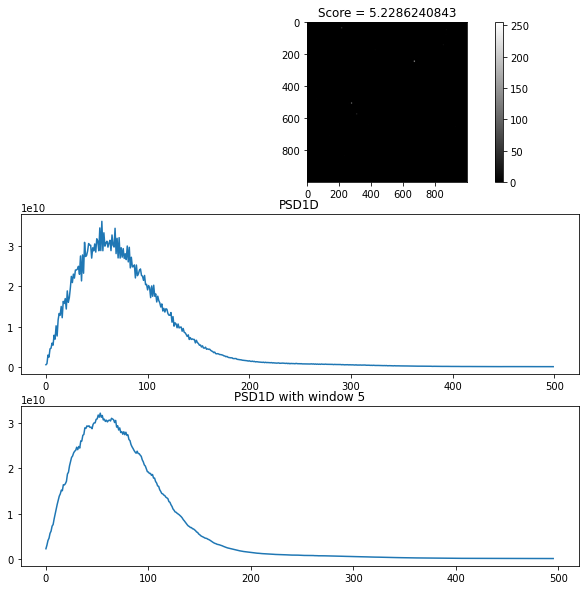

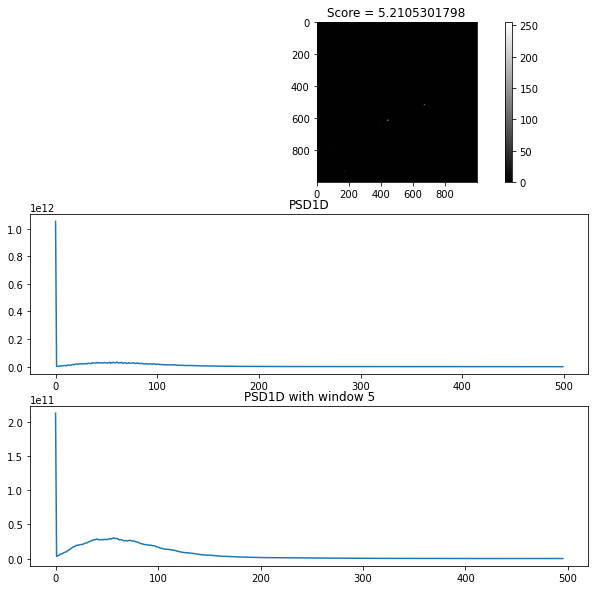

=== Score is  6


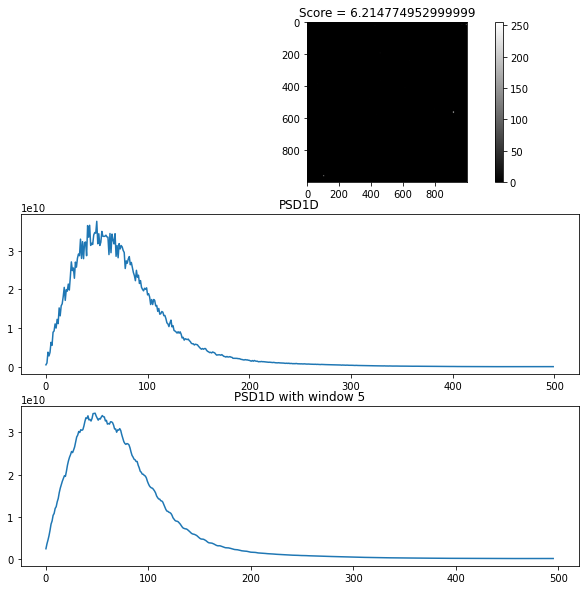

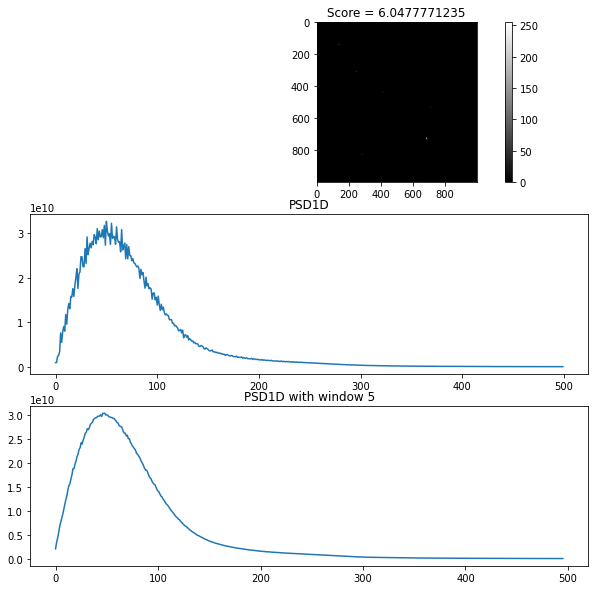

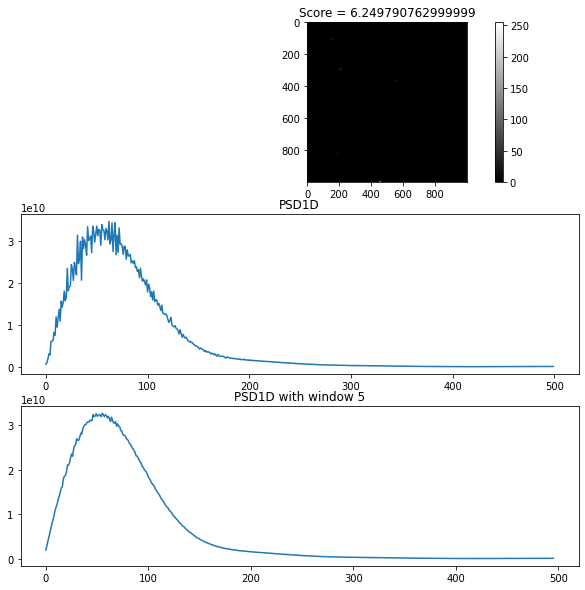

=== Score is  7
=== Score is  8
done


In [82]:
# visualize the features for each score
# max score is 8
# get 5 images for each score and display features before and after windowing
for score_thresh in range(9):
  print('=== Score is ', score_thresh)

  # get some images in range [thresh, thresh+1]
  filtered_scores = scores[scores["Actual"] > score_thresh]
  filtered_scores = filtered_scores[filtered_scores["Actual"] < score_thresh+1]
  filtered_scores = filtered_scores[:5] # get only 5 - should be enough
 
  for index, row in filtered_scores.iterrows():
    # Load image
    # print(index)
    img_path = os.path.join(path_scored, str(index) + ".png")
    img = cv2.imread(img_path,0)

    # FFT
    f = np.fft.fft2(img)

    # Move 0 freq to center - not really necessary but images look better 
    fshift = np.fft.fftshift(f)
   
    plt.figure(figsize=(10, 10))

    plt.subplot(311),plt.imshow(img, cmap = 'gray')
    plt.colorbar()
    plt.title('Score = ' + str(row["Actual"]))

    psd1d = GetPSD1D(np.abs(fshift) ** 2)
    plt.subplot(312),plt.plot(psd1d)
    plt.title('PSD1D')

    result = []
    for i in range(len(psd1d) - window_len + 1):
      element = 0
      for j in range(window_len):
        element = element + psd1d[i + j]
      result.append(element / window_len)

    plt.subplot(313),plt.plot(result)
    plt.title('PSD1D with window ' + str(window_len))

    if save_visualize:
      plt.savefig("{}PSD1D_window{}_score{}_id{}".format(save_path, window_len, score_thresh, index))
    
    plt.show()
    plt.close()

print("done")
    

# Get the features of the SCORED images

In [0]:
number_features = 500 - window_len + 1

In [84]:
number_features_list = list(range(number_features))
cols = ['Id', 'Actual']
cols.extend(number_features_list)

print(cols)

['Id', 'Actual', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

In [85]:
df = pd.DataFrame(columns=cols)
df.set_index('Id')
print(df)

Empty DataFrame
Columns: [Id, Actual, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, ...]
Index: []

[0 rows x 498 columns]


In [0]:
display_plots = False

In [87]:
count = 0
percent = int(len(scores.index) * 0.01) # to display progress

for index, row in scores.iterrows():
  # Load image
  img_path = os.path.join(path_scored, str(index) + ".png")
  img = cv2.imread(img_path,0)

  # apply fft
  f = np.fft.fft2(img)

  # Move 0 freq to center - not really necessary but images look better 
  fshift = np.fft.fftshift(f)

  # get features
  psd1d = GetPSD1D(np.abs(fshift) ** 2)
  
  # apply window
  img_features = []
  for i in range(len(psd1d) - window_len + 1):
    element = 0
    for j in range(window_len):
      element = element + psd1d[i + j]
    img_features.append(element / window_len)

  # add actual score to the row entry 
  img_features.insert(0, row["Actual"]) 

  # add image ID to row entry
  img_features.insert(0, index) 

  # create row to add to dataset 
  this_row = pd.DataFrame([img_features], columns=cols)
  df = df.append(this_row)
  
  count = count + 1  
  if (count % percent == 0):
    print(".............. Done {}%".format(count / percent))
  
print("done")
    

.............. Done 1.0%
.............. Done 2.0%
.............. Done 3.0%
.............. Done 4.0%
.............. Done 5.0%
.............. Done 6.0%
.............. Done 7.0%
.............. Done 8.0%
.............. Done 9.0%
.............. Done 10.0%
.............. Done 11.0%
.............. Done 12.0%
.............. Done 13.0%
.............. Done 14.0%
.............. Done 15.0%
.............. Done 16.0%
.............. Done 17.0%
.............. Done 18.0%
.............. Done 19.0%
.............. Done 20.0%
.............. Done 21.0%
.............. Done 22.0%
.............. Done 23.0%
.............. Done 24.0%
.............. Done 25.0%
.............. Done 26.0%
.............. Done 27.0%
.............. Done 28.0%
.............. Done 29.0%
.............. Done 30.0%
.............. Done 31.0%
.............. Done 32.0%
.............. Done 33.0%
.............. Done 34.0%
.............. Done 35.0%
.............. Done 36.0%
.............. Done 37.0%
.............. Done 38.0%
.............. Done 3

In [88]:
df

,Id,Actual,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495
0,5694059,1.837794,1.107440e+09,1.667032e+09,2.130959e+09,2.664036e+09,3.173489e+09,3.670987e+09,4.169022e+09,4.543887e+09,5.055839e+09,5.638340e+09,6.023111e+09,6.420306e+09,6.960776e+09,7.459536e+09,7.754481e+09,8.358685e+09,8.719312e+09,9.218116e+09,9.448498e+09,9.907736e+09,1.015152e+10,1.059275e+10,1.117359e+10,1.140019e+10,1.155163e+10,1.216813e+10,1.239303e+10,1.254208e+10,1.313341e+10,1.345586e+10,1.362496e+10,1.386259e+10,1.410294e+10,1.407466e+10,1.476293e+10,1.487186e+10,1.488653e+10,1.517532e+10,...,4.421564e+07,4.408875e+07,4.374515e+07,4.377600e+07,4.362373e+07,4.378876e+07,4.352319e+07,4.330521e+07,4.322337e+07,4.315534e+07,4.316548e+07,4.299109e+07,4.303091e+07,4.290669e+07,4.286338e+07,4.292169e+07,4.274427e+07,4.267851e+07,4.291608e+07,4.265490e+07,4.269490e+07,4.270610e+07,4.303303e+07,4.276341e+07,4.271837e+07,4.278143e+07,4.260990e+07,4.297097e+07,4.289432e+07,4.294334e+07,4.280282e+07,4.299589e+07,4.274403e+07,4.284448e+07,4.295897e+07,4.314930e+07,4.300254e+07,4.314061e+07,4.312987e+07,4.325063e+07
0,9129611,0.002067,2.504742e+12,2.408613e+09,2.829976e+09,3.537266e+09,4.296399e+09,4.891684e+09,4.908616e+09,5.796001e+09,6.470846e+09,7.076565e+09,7.577329e+09,8.575959e+09,9.049568e+09,9.449736e+09,1.006138e+10,1.091656e+10,1.089535e+10,1.197301e+10,1.268605e+10,1.349356e+10,1.407114e+10,1.518193e+10,1.516854e+10,1.572270e+10,1.597777e+10,1.653782e+10,1.692733e+10,1.755742e+10,1.827582e+10,1.814970e+10,1.873444e+10,1.883420e+10,1.873158e+10,1.880277e+10,2.023740e+10,2.073510e+10,2.063661e+10,2.153231e+10,...,8.335344e+10,8.347109e+10,8.293868e+10,8.280759e+10,8.218597e+10,8.248348e+10,8.247354e+10,8.325124e+10,8.403779e+10,8.358640e+10,8.297362e+10,8.315926e+10,8.308748e+10,8.242696e+10,8.397397e+10,8.423771e+10,8.456970e+10,8.441422e+10,8.557282e+10,8.564133e+10,8.684658e+10,8.699139e+10,8.774907e+10,8.710819e+10,8.662183e+10,8.705725e+10,8.679128e+10,8.680920e+10,8.759312e+10,8.805388e+10,8.660329e+10,8.656854e+10,8.759950e+10,8.740089e+10,8.763096e+10,8.955764e+10,8.969176e+10,8.983097e+10,8.949935e+10,8.955881e+10
0,8058479,4.588517,2.123252e+11,4.083610e+09,5.197446e+09,6.298243e+09,7.648910e+09,8.966001e+09,9.846370e+09,1.100680e+10,1.198638e+10,1.347168e+10,1.448369e+10,1.583534e+10,1.682463e+10,1.832812e+10,1.862473e+10,2.001377e+10,2.020929e+10,2.198812e+10,2.229293e+10,2.322635e+10,2.398535e+10,2.548946e+10,2.626924e+10,2.719211e+10,2.772161e+10,2.891593e+10,2.913736e+10,2.935336e+10,3.024949e+10,3.085080e+10,3.167335e+10,3.196112e+10,3.257101e+10,3.278531e+10,3.420356e+10,3.336506e+10,3.442215e+10,3.456986e+10,...,1.461861e+08,1.450536e+08,1.428774e+08,1.426026e+08,1.411115e+08,1.404919e+08,1.400123e+08,1.379532e+08,1.364219e+08,1.352185e+08,1.351804e+08,1.330914e+08,1.319434e+08,1.298337e+08,1.294563e+08,1.274317e+08,1.257341e+08,1.246674e+08,1.245356e+08,1.224375e+08,1.209943e+08,1.198074e+08,1.187749e+08,1.172683e+08,1.156330e+08,1.138063e+08,1.120464e+08,1.114724e+08,1.098088e+08,1.085297e+08,1.070798e+08,1.065757e+08,1.044068e+08,1.029241e+08,1.018830e+08,1.011299e+08,9.899339e+07,9.796317e+07,9.640300e+07,9.540527e+07
0,1315360,2.325835,8.251190e+11,6.450185e+09,7.952331e+09,9.788791e+09,1.198526e+10,1.391807e+10,1.526232e+10,1.688832e+10,1.888684e+10,2.058522e+10,2.206157e+10,2.362286e+10,2.511678e+10,2.701278e+10,2.832822e+10,2.942013e+10,3.099284e+10,3.322442e+10,3.341755e+10,3.397133e+10,3.547826e+10,3.681266e+10,3.786218e+10,3.868539e+10,3.958031e+10,4.087495e+10,4.078294e+10,4.153288e+10,4.252169e+10,4.320026e+10,4.382752e+10,4.424457e+10,4.386139e+10,4.413925e+10,4.524807e+10,4.456755e+10,4.468499e+10,4.530212e+10,...,2.043314e+08,1.992139e+08,1.942185e+08,1.904773e+08,1.864884e+08,1.835565e+08,1.796864e+08,1.

In [0]:
if save_csv: 
  csv_name = "{}PSD1D_scored_features{}_window{}.csv".format(cil_project_path, number_feeatures, window_len)
  df.to_csv(csv_name)

# Get the features out of the QUERY images


In [0]:
from os import listdir
from os.path import isfile, join

In [91]:
# make a list with IDs of images in the query folder
files = [f[:-4] for f in listdir(path_query) if isfile(join(path_query, f))]

files[:5]

['8362896', '1366237', '2620117', '4814304', '4767248']

In [92]:
number_features_list = list(range(number_features))
cols = ['Id']
cols.extend(number_features_list)

print(cols)

df_query = pd.DataFrame(columns=cols)
df_query.set_index('Id')
print(df_query)

['Id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

In [93]:
count = 0
percent = int(len(files) * 0.01)

for index in files:
  # Load image
  img_path = os.path.join(path_query, str(index) + ".png")
  img = cv2.imread(img_path,0)

  # FFT
  f = np.fft.fft2(img)

  # move 0 freq to center
  fshift = np.fft.fftshift(f)
  
  # get features
  psd1d = GetPSD1D(np.abs(fshift) ** 2)

  # apply window
  img_features = []
  for i in range(len(psd1d) - window_len + 1):
    element = 0
    for j in range(window_len):
      element = element + psd1d[i + j]
    img_features.append(element / window_len)

  # add image ID to row
  img_features.insert(0, index) 

  # insert row to query dataframe
  this_row = pd.DataFrame([img_features], columns=cols)
  df_query = df_query.append(this_row)

  # display progress
  count = count + 1  
  if(count % percent == 0):
    print("... Done {}%".format(count / percent))

print("done")
    

... Done 1.0%
... Done 2.0%
... Done 3.0%
... Done 4.0%
... Done 5.0%
... Done 6.0%
... Done 7.0%
... Done 8.0%
... Done 9.0%
... Done 10.0%
... Done 11.0%
... Done 12.0%
... Done 13.0%
... Done 14.0%
... Done 15.0%
... Done 16.0%
... Done 17.0%
... Done 18.0%
... Done 19.0%
... Done 20.0%
... Done 21.0%
... Done 22.0%
... Done 23.0%
... Done 24.0%
... Done 25.0%
... Done 26.0%
... Done 27.0%
... Done 28.0%
... Done 29.0%
... Done 30.0%
... Done 31.0%
... Done 32.0%
... Done 33.0%
... Done 34.0%
... Done 35.0%
... Done 36.0%
... Done 37.0%
... Done 38.0%
... Done 39.0%
... Done 40.0%
... Done 41.0%
... Done 42.0%
... Done 43.0%
... Done 44.0%
... Done 45.0%
... Done 46.0%
... Done 47.0%
... Done 48.0%
... Done 49.0%
... Done 50.0%
... Done 51.0%
... Done 52.0%
... Done 53.0%
... Done 54.0%
... Done 55.0%
... Done 56.0%
... Done 57.0%
... Done 58.0%
... Done 59.0%
... Done 60.0%
... Done 61.0%
... Done 62.0%
... Done 63.0%
... Done 64.0%
... Done 65.0%
... Done 66.0%
... Done 67.0%
... 

In [94]:
df_query

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495
0,8362896,3.714519e+09,5.378962e+09,6.619727e+09,8.155101e+09,9.421313e+09,1.093138e+10,1.208372e+10,1.379528e+10,1.487519e+10,1.772228e+10,1.887160e+10,2.020122e+10,2.132944e+10,2.364928e+10,2.384203e+10,2.441523e+10,2.576638e+10,2.738089e+10,2.789589e+10,2.827781e+10,3.087119e+10,3.194573e+10,3.426426e+10,3.509166e+10,3.607021e+10,3.646352e+10,3.727441e+10,3.672577e+10,3.682978e+10,3.829244e+10,3.928254e+10,3.966090e+10,4.014865e+10,4.170191e+10,4.289227e+10,4.335494e+10,4.378478e+10,4.434834e+10,4.414967e+10,...,1.304763e+08,1.316318e+08,1.318018e+08,1.326546e+08,1.340638e+08,1.357146e+08,1.359523e+08,1.363853e+08,1.379016e+08,1.384670e+08,1.392332e+08,1.408283e+08,1.419655e+08,1.414893e+08,1.430499e+08,1.447916e+08,1.449071e+08,1.454724e+08,1.473423e+08,1.472393e+08,1.475114e+08,1.493656e+08,1.505443e+08,1.512345e+08,1.516178e+08,1.525428e+08,1.522871e+08,1.542049e+08,1.552867e+08,1.562832e+08,1.566375e+08,1.574859e+08,1.568596e+08,1.579945e+08,1.588640e+08,1.600412e+08,1.602726e+08,1.614490e+08,1.608701e+08,1.619805e+08
0,1366237,2.946656e+09,4.577593e+09,5.728703e+09,7.198559e+09,8.316952e+09,1.002906e+10,1.075816e+10,1.256178e+10,1.342159e+10,1.537274e+10,1.646208e+10,1.757586e+10,1.868643e+10,1.976646e+10,2.069517e+10,2.169203e+10,2.311985e+10,2.443240e+10,2.559035e+10,2.609341e+10,2.717669e+10,2.845953e+10,2.946537e+10,3.025045e+10,3.068589e+10,3.208271e+10,3.234214e+10,3.314620e+10,3.368794e+10,3.543500e+10,3.594895e+10,3.628800e+10,3.675762e+10,3.717010e+10,3.772463e+10,3.791254e+10,3.872944e+10,3.862584e+10,3.971254e+10,...,1.655666e+08,1.661394e+08,1.646187e+08,1.647416e+08,1.636513e+08,1.638314e+08,1.629558e+08,1.623131e+08,1.614288e+08,1.606905e+08,1.613030e+08,1.594786e+08,1.591787e+08,1.578049e+08,1.584554e+08,1.574980e+08,1.568663e+08,1.556337e+08,1.555523e+08,1.539773e+08,1.529071e+08,1.526571e+08,1.526044e+08,1.520562e+08,1.503025e+08,1.496666e+08,1.479409e+08,1.483885e+08,1.471925e+08,1.466676e+08,1.449942e+08,1.450443e+08,1.427191e+08,1.423396e+08,1.418809e+08,1.421418e+08,1.407700e+08,1.401442e+08,1.386698e+08,1.379005e+08
0,2620117,1.739254e+09,2.845826e+09,3.497095e+09,4.310284e+09,5.179655e+09,5.909667e+09,6.761099e+09,7.447220e+09,8.140326e+09,9.278817e+09,9.885042e+09,1.053578e+10,1.158102e+10,1.213647e+10,1.279277e+10,1.369569e+10,1.406345e+10,1.525446e+10,1.578024e+10,1.605612e+10,1.681777e+10,1.767736e+10,1.838274e+10,1.882738e+10,1.940111e+10,2.034352e+10,2.040775e+10,2.105818e+10,2.149730e+10,2.229562e+10,2.300978e+10,2.301038e+10,2.331018e+10,2.377625e+10,2.430517e+10,2.462218e+10,2.497539e+10,2.549196e+10,2.627289e+10,...,8.778882e+07,8.727711e+07,8.665723e+07,8.622480e+07,8.568249e+07,8.583701e+07,8.516760e+07,8.440505e+07,8.401314e+07,8.392893e+07,8.359123e+07,8.301651e+07,8.281199e+07,8.231213e+07,8.156477e+07,8.124080e+07,8.046732e+07,8.008515e+07,7.995602e+07,7.938910e+07,7.915991e+07,7.883238e+07,7.902584e+07,7.827014e+07,7.785321e+07,7.743457e+07,7.685181e+07,7.695946e+07,7.680952e+07,7.627987e+07,7.565339e+07,7.583500e+07,7.498285e+07,7.457174e+07,7.490425e+07,7.518858e+07,7.443197e+07,7.452541e+07,7.443319e+07,7.402967e+07
0,4814304,1.390039e+09,2.139124e+09,2.574906e+09,2.990317e+09,3.765133e+09,4.286118e+09,4.805559e+09,5.551443e+09,6.250830e+09,6.821983e+09,7.643851e+09,8.096580e+09,8.266434e+09,8.723541e+09,9.539215e+09,9.854963e+09,1.007680e+10,1.096535e+10,1.185522e+10,1.187794e+10,1.242302e+10,1.311022e+10,1.393728e+10,1.404569e+10,1.436736e+10,1.491990e+10,1.501574e+10,1.494283e+10,1.587045e+10,1.649149e+10,1.679155e+10,1.710707e+10,1.795201e+10,1.818718e+10,1.824773e+10,1.808810e+10,1.869142e+10,1.852421e+10,1.864062e+10,...,5.564175e+07,5.467067e+07,5.362703e+07,5.296327e+07,5.201442e+07,5.159921e+07,5.0

In [0]:
if save_csv: 
  csv_name = "{}PSD1D_query_features{}_window{}.csv".format(cil_project_path, number_feeatures, window_len)
  df_query.to_csv(csv_name)